In [56]:
from sklearn.linear_model import LogisticRegression, LinearRegression
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [57]:
x_train = pd.read_csv('../data/xtrain.csv')
x_test = pd.read_csv('../data/xtest.csv')

y_train = pd.read_csv('../data/ytrain.csv')
y_test = pd.read_csv('../data/ytest.csv')

x_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,sulphates,alcohol
0,0.773501,-1.155577,1.377721,-0.020843,0.141645,1.229206,1.219960,1.038601,-0.764699
1,-0.015276,0.457965,0.151175,-0.307974,-0.072755,-0.446073,0.149557,-0.280099,-0.206533
2,-0.296983,-1.044298,0.508918,-0.379757,-0.115636,0.835022,0.409049,-0.405690,-0.950754
3,0.153747,-0.877380,1.939888,2.778692,-0.158516,-1.234439,-1.212775,-0.468485,0.537688
4,0.322771,-0.265347,1.326615,1.055901,0.291726,-1.234439,-1.147902,-0.405690,1.560992


In [58]:
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [59]:
model = LogisticRegression(C=0.005, random_state=0)
model.fit(x_train, y_train)

LogisticRegression(C=0.005, random_state=0)

In [60]:
# perform evaluation on test set

predictions = model.predict(x_test)
probas = model.predict_proba(x_test)[:, 1]

accuracy_score(predictions, y_test)
print(f"accuracy:{accuracy_score(y_test, predictions)}")
print(f"roc: {roc_auc_score(y_test, probas)}")



accuracy:0.8679245283018868
roc: 0.777087646652864


In [61]:
# classification_models to try

classifiers = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', GridSearchCV(
            LogisticRegression(penalty='l2', solver='liblinear', random_state=42),
            param_grid={'C': [0.01, 0.1, 1.0, 10]},
            cv=5))
    ]),
    'KNN Classifier': Pipeline([
        ('scaler', StandardScaler()),
        ('knn', GridSearchCV(KNeighborsClassifier(), param_grid={'n_neighbors': [3, 5, 7, 9]}, cv=5))
    ]),
    'Support Vector Classifier': Pipeline([
        ('scaler', StandardScaler()),
        ('svc', GridSearchCV(SVC(probability=True, random_state=42), param_grid={
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale', 'auto']
        }, cv=5))
    ]),
    'Stochastic Gradient Descent Classifier': Pipeline([
        ('scaler', StandardScaler()),
        ('sgd', GridSearchCV(SGDClassifier(random_state=42), param_grid={
            'alpha': [1e-4, 1e-3, 1e-2],
            'penalty': ['l2', 'l1', 'elasticnet'],
            'max_iter': [1000, 2000],
            'learning_rate': ['constant', 'optimal', 'adaptive'],
            'eta0': [0.001, 0.01]  # ensures that a nonzero learning rate is applied whenever learning_rate='constant' is used.
        }, cv=5, error_score='raise'))
    ]),
    'Random Forest Classifier': Pipeline([
        ('scaler', StandardScaler()),
        ('rf', GridSearchCV(RandomForestClassifier(random_state=42), param_grid={'n_estimators': [50, 100, 200]}, cv=5))
    ]),
    'Gradient Boosting Classifier': Pipeline([
        ('scaler', StandardScaler()),
        ('gb', GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid={'n_estimators': [50, 100, 200], 'learning_rate': [0.05, 0.1, 0.2]}, cv=5))
    ])
}


Training Logistic Regression
Logistic Regression Accuracy: 0.8616352201257862 Variance: 0.0955
Best hyperparameters for Logistic Regression: {'C': 10}
auc score: 0.7877846790890269


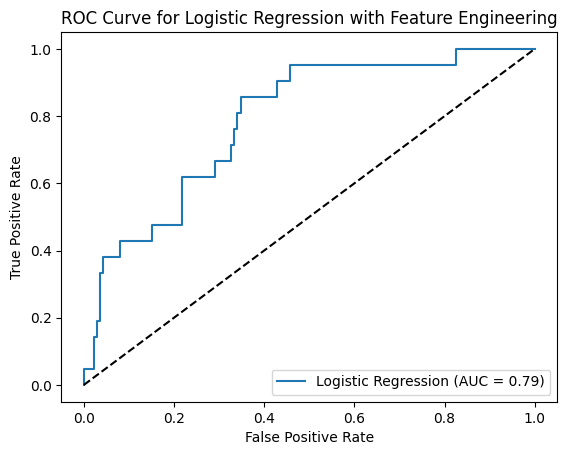


Training KNN Classifier
KNN Classifier Accuracy: 0.8930817610062893 Variance: 0.1100
Best hyperparameters for KNN Classifier: {'n_neighbors': 3}
auc score: 0.831608005521049


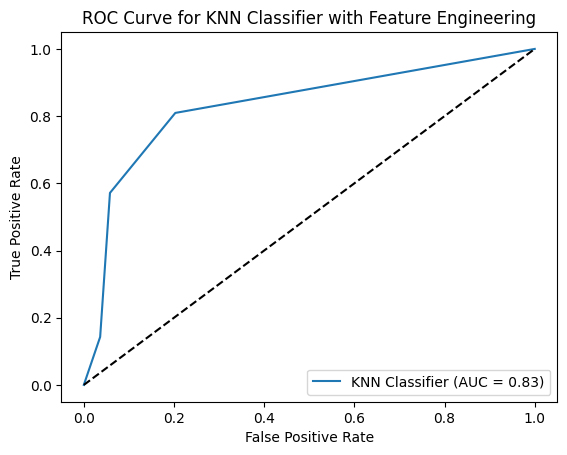


Training Support Vector Classifier
Support Vector Classifier Accuracy: 0.8867924528301887 Variance: 0.0955
Best hyperparameters for Support Vector Classifier: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
auc score: 0.7763975155279503


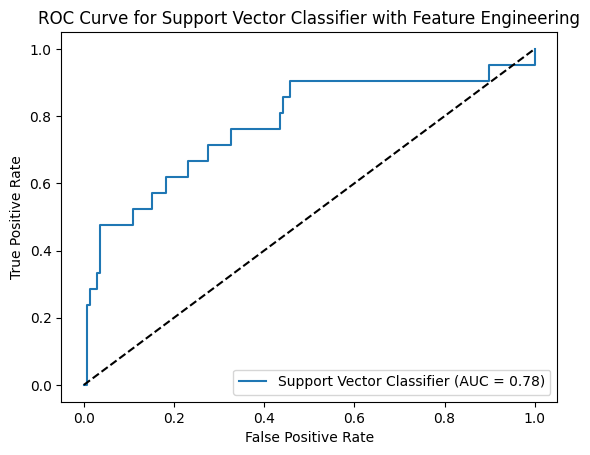


Training Stochastic Gradient Descent Classifier
Stochastic Gradient Descent Classifier Accuracy: 0.8616352201257862 Variance: 0.0062
Best hyperparameters for Stochastic Gradient Descent Classifier: {'alpha': 0.001, 'eta0': 0.001, 'learning_rate': 'optimal', 'max_iter': 1000, 'penalty': 'l2'}

Training Random Forest Classifier
Random Forest Classifier Accuracy: 0.9119496855345912 Variance: 0.1052
Best hyperparameters for Random Forest Classifier: {'n_estimators': 200}
auc score: 0.9177018633540373


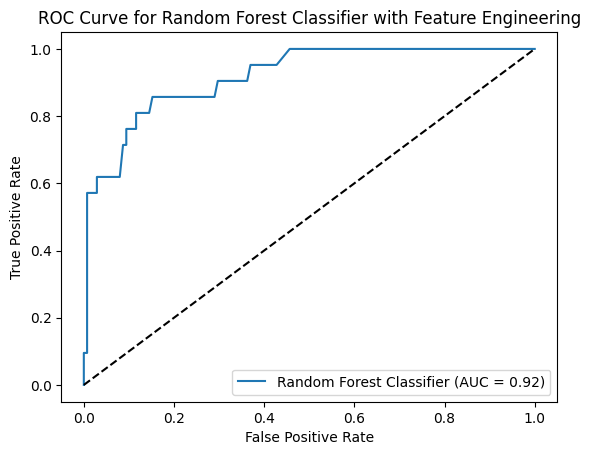


Training Gradient Boosting Classifier
Gradient Boosting Classifier Accuracy: 0.8867924528301887 Variance: 0.1052
Best hyperparameters for Gradient Boosting Classifier: {'learning_rate': 0.2, 'n_estimators': 100}
auc score: 0.8671497584541061


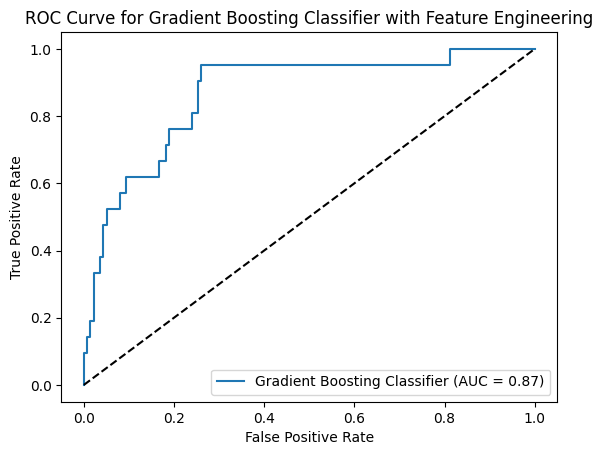

In [62]:
for classifier_name, classifier_pipeline in classifiers.items():
    print(f"\nTraining {classifier_name}")
    classifier_pipeline.fit(x_train, y_train)
    
    y_pred = classifier_pipeline.predict(x_test)
    prediction_variance = np.var(y_pred)
    print(f"{classifier_name} Accuracy: {accuracy_score(y_test, y_pred)} Variance: {prediction_variance:.4f}")
    
    for step_name, step in classifier_pipeline.named_steps.items():
        if isinstance(step, GridSearchCV):
            print(f"Best hyperparameters for {classifier_name}: {step.best_params_}")

    
    
    if hasattr(classifier_pipeline, "predict_proba"):
        y_proba = classifier_pipeline.predict_proba(x_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_proba)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        print(f"auc score: {auc_score}")

        plt.figure()
        plt.plot(fpr, tpr, label=f'{classifier_name} (AUC = {auc_score:.2f})')
        plt.plot([0, 1], [0, 1], 'k--') 
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {classifier_name} with Feature Engineering')
        plt.legend(loc='lower right')
        plt.show()